In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(palette='bright', context='talk', style='whitegrid')

import warnings
warnings.filterwarnings(action='ignore')

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score
plt.rcParams["figure.figsize"] = (20, 10)

In [2]:
filename_train = 'train.csv.zip'
filename_test = 'test.csv'
train_df = pd.read_csv(filename_train, compression='zip')
test_df = pd.read_csv(filename_test)

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [3]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [5]:
#sns.pairplot(train_df.iloc[0:100, :])

In [6]:
def reduce_mem_usage(dataset, avoid):
    start_mem_usg = round(dataset.memory_usage().sum() / 1024**2, 2)
    print("Memory usage of dataframe is :",start_mem_usg," MB")
    NA_array = [] # Keeps track of columns that have missing values filled in. 
    for col in dataset.columns:
        if dataset[col].dtype != (object or 'string') and col not in avoid:  # Exclude strings
            
            # Print current column type
            print("*"*80)
            print("Column: ",col)
            print("dtype before: ", dataset[col].dtype)
            
            # make variables for Int, max and min
            is_int = False
            max_val = dataset[col].max()
            min_val = dataset[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(dataset[col]).all(): 
                NA_array.append(col)
                dataset[col].fillna(min_val-1, inplace = True)  
                   
            # test if column can be converted to an integer
            as_int = dataset[col].fillna(0).astype(np.int64)
            result = (dataset[col] - as_int)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                is_int = True

            
            # Make Integer/unsigned Integer datatypes
            if is_int:
                if min_val >= 0:
                    if max_val < 255:
                        dataset[col] = dataset[col].astype(np.uint8)
                    elif max_val < 65535:
                        dataset[col] = dataset[col].astype(np.uint16)
                    elif max_val < 4294967295:
                        dataset[col] = dataset[col].astype(np.uint32)
                    else:
                        dataset[col] = dataset[col].astype(np.uint64)
                else:
                    if min_val > np.iinfo(np.int8).min and max_val < np.iinfo(np.int8).max:
                        dataset[col] = dataset[col].astype(np.int8)
                    elif min_val > np.iinfo(np.int16).min and max_val < np.iinfo(np.int16).max:
                        dataset[col] = dataset[col].astype(np.int16)
                    elif min_val > np.iinfo(np.int32).min and max_val < np.iinfo(np.int32).max:
                        dataset[col] = dataset[col].astype(np.int32)
                    elif min_val > np.iinfo(np.int64).min and max_val < np.iinfo(np.int64).max:
                        dataset[col] = dataset[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                dataset[col] = dataset[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",dataset[col].dtype)
            print("*"*80)
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = round(dataset.memory_usage().sum() / 1024**2, 2) 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",round(100*mem_usg/start_mem_usg, 2),"% of the initial size")
    return dataset, NA_array

Decrease the size of the dataframe given and avoid any changes for selected features (e.g., those containing NaN).

In [7]:
nan_values = train_df.isna()
nan_columns = nan_values.any()
avoid_list = train_df.columns[nan_columns].tolist() # list column names where some values are NaN
as_str = ['Id', 'DistrictId']
for el in as_str:
    avoid_list.append(el)
avoid_list

['LifeSquare', 'Healthcare_1', 'Id', 'DistrictId']

In [8]:
train_df_mod, NA_train_array = reduce_mem_usage(train_df.copy(), avoid_list)

Memory usage of dataframe is : 1.53  MB
********************************************************************************
Column:  Rooms
dtype before:  float64
dtype after:  uint8
********************************************************************************
********************************************************************************
Column:  Square
dtype before:  float64
dtype after:  float32
********************************************************************************
********************************************************************************
Column:  KitchenSquare
dtype before:  float64
dtype after:  uint16
********************************************************************************
********************************************************************************
Column:  Floor
dtype before:  int64
dtype after:  uint8
********************************************************************************
**********************************************************************

In [9]:
train_df_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  uint8  
 3   Square         10000 non-null  float32
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  uint16 
 6   Floor          10000 non-null  uint8  
 7   HouseFloor     10000 non-null  uint8  
 8   HouseYear      10000 non-null  uint32 
 9   Ecology_1      10000 non-null  float32
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  uint8  
 13  Social_2       10000 non-null  uint16 
 14  Social_3       10000 non-null  uint8  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  uint8  
 17  Shops_1        10000 non-null  uint8  
 18  Shops_2

In [10]:
test_df_mod, NA_test_array = reduce_mem_usage(test_df.copy(), avoid_list)

Memory usage of dataframe is : 0.72  MB
********************************************************************************
Column:  Rooms
dtype before:  float64
dtype after:  uint8
********************************************************************************
********************************************************************************
Column:  Square
dtype before:  float64
dtype after:  float32
********************************************************************************
********************************************************************************
Column:  KitchenSquare
dtype before:  float64
dtype after:  uint16
********************************************************************************
********************************************************************************
Column:  Floor
dtype before:  int64
dtype after:  uint8
********************************************************************************
**********************************************************************

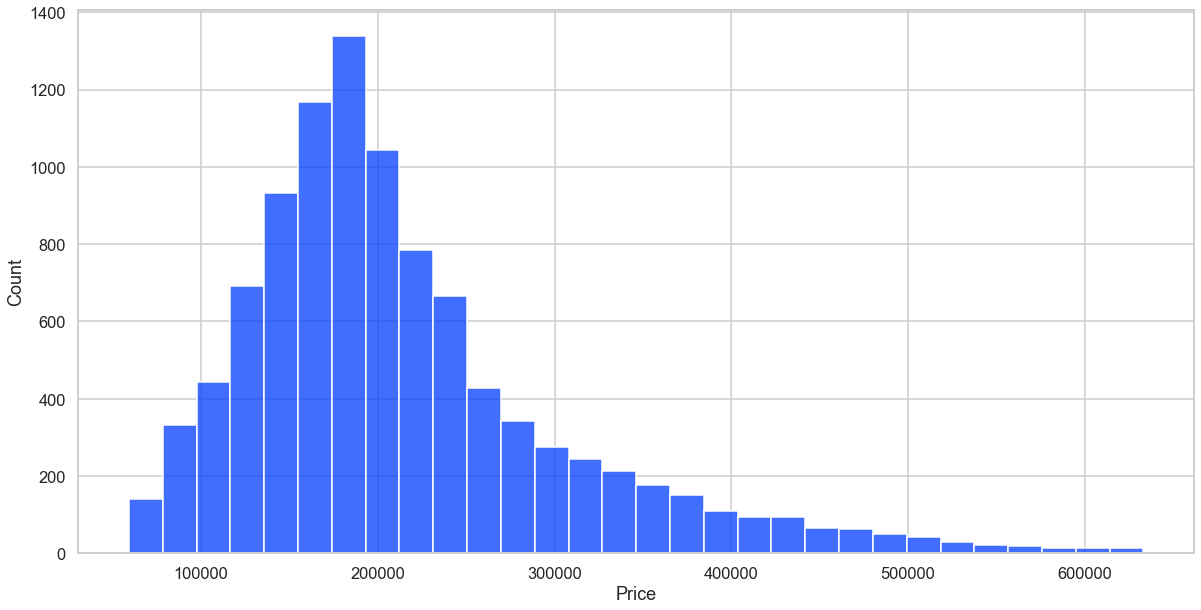

In [11]:
sns.histplot(train_df_mod['Price'], bins=30)
plt.show()

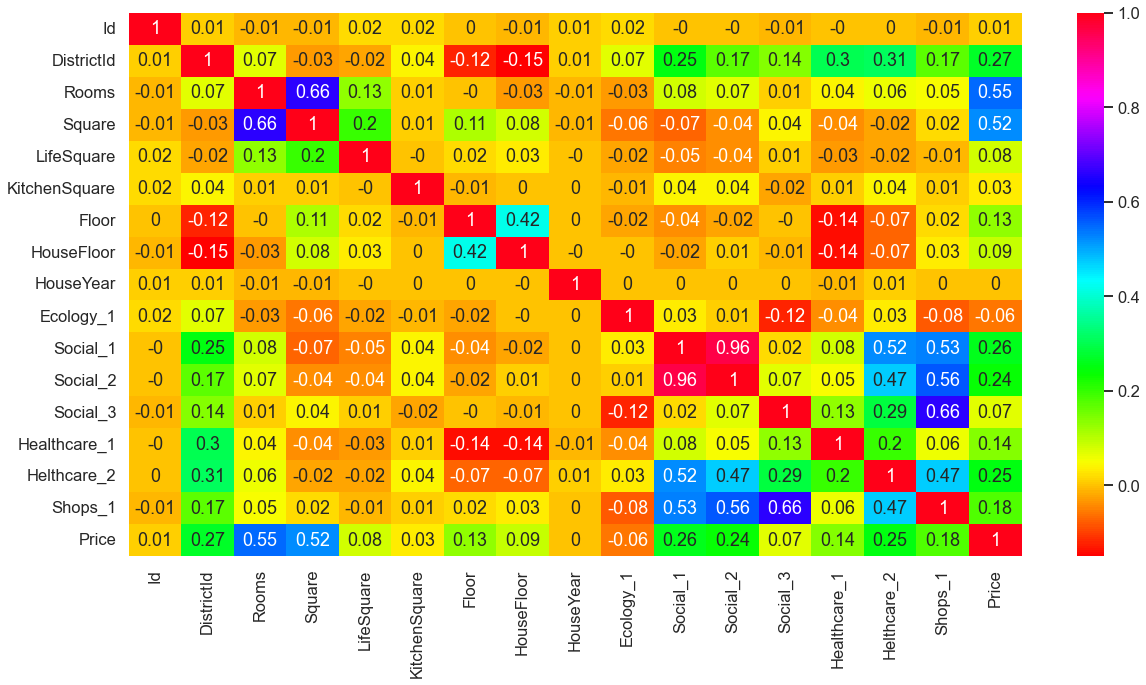

In [12]:
corr_values = round(train_df_mod.corr(), 2)
sns.heatmap(corr_values, annot=True, cmap='hsv')
plt.show()

In [13]:
important_features = corr_values.loc[corr_values['Price'] > 0.4].index.tolist()
important_features.append('DistrictId')
important_features_test = important_features.copy()
important_features_test.remove('Price')

It appears that the most important parameters are <b>*Rooms*</b> and <b>*Square*</b> only. Hence, first prediction attempt will rely on these features only. <b>*DistrictID*</b> feature is necessary to compute the average price per square meter for a certain district.

In [14]:
class DataModifier:
    def __init__(self):
        self.max_square = None
        self.min_square = None
        self.max_rooms = None
        self.min_rooms = None
    
    def fit(self, ds):
        self.max_square = np.quantile(ds['Square'], q=0.975)
        self.min_square = np.quantile(ds['Square'], q=0.025)
        self.max_rooms = np.quantile(ds['Rooms'], q=0.975)
        self.min_rooms = np.quantile(ds['Rooms'], q=0.025)
    
    def transfrom(self, ds):
        ds.loc[ds['Rooms']>5, 'Rooms'] = self.max_rooms
        ds.loc[ds['Rooms']<1, 'Rooms'] = self.min_rooms
        ds.loc[ds['Square']>self.max_square, 'Square'] = self.max_square
        ds.loc[ds['Square']<self.min_square, 'Square'] = self.min_square
        return ds

In [15]:
class FeatureSelector:
    def __init__(self):
        self.mean_square_district_price = None
    
    def add_features(self, ds):
        self.mean_square_district_price.to_dict()
        ds['MeanDistrictPrice'] = ds['DistrictId'].map(self.mean_square_district_price)
        self.median_square_district_price = ds['MeanDistrictPrice'].median()
        ds['MeanDistrictPrice'].fillna(self.median_square_district_price, inplace=True)
        ds.drop('DistrictId', axis=1, inplace=True)
        return ds
    
    def fit(self, ds):
        self.mean_square_district_price = ds.groupby('DistrictId')['Price'].agg('median')/ds.groupby('DistrictId')['Square'].agg('median')

In [16]:
data_mod = DataModifier()
modified_train = train_df_mod[important_features]
modified_test = test_df_mod[important_features_test]
data_mod.fit(modified_train)
modified_train = data_mod.transfrom(modified_train)
data_mod.fit(modified_test)
modified_test = data_mod.transfrom(modified_test)

In [17]:
modified_train.describe()

,Rooms,Square,Price,DistrictId
count,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.88800,55.808048,214138.937500,50.400800
std,0.81174,17.214579,92872.273438,43.587592
min,1.00000,32.105183,59174.777344,0.000000
25%,1.00000,41.774879,153872.628906,20.000000
50%,2.00000,52.513309,192269.648438,36.000000
75%,2.00000,65.900627,249135.460938,75.000000
max,5.00000,100.906250,633233.437500,209.000000


In [18]:
feat_select = FeatureSelector()
feat_select.fit(modified_train)
final_train = feat_select.add_features(modified_train)
to_validate = feat_select.add_features(modified_test)

In [19]:
final_train.describe()

,Rooms,Square,Price,MeanDistrictPrice
count,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.88800,55.808048,214138.937500,3820.127930
std,0.81174,17.214579,92872.273438,988.402161
min,1.00000,32.105183,59174.777344,2109.194580
25%,1.00000,41.774879,153872.628906,2955.305908
50%,2.00000,52.513309,192269.648438,3970.074707
75%,2.00000,65.900627,249135.460938,4410.052856
max,5.00000,100.906250,633233.437500,8361.390625


In [20]:
to_validate.describe()

,Rooms,Square,MeanDistrictPrice
count,5000.000000,5000.000000,5000.000000
mean,1.906400,56.125488,3833.169189
std,0.806579,17.256643,975.068604
min,1.000000,32.113304,2109.194580
25%,1.000000,41.906230,2994.023682
50%,2.000000,52.921339,3975.516357
75%,2.000000,66.285130,4422.596680
max,5.000000,100.733429,8361.390625


In [21]:
y = final_train['Price']
X = final_train.drop('Price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
from sklearn.ensemble import RandomForestRegressor

In [23]:
# from sklearn.model_selection import RandomizedSearchCV
# # finding optimal parameters for RandomForest
# n_estimators = [x for x in range(100, 2001, 100)]
# max_features = ['auto', 'sqrt']
# max_depth = [x for x in range(5, 101, 5)]
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]

# grid_param = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

In [24]:
# rf_model = RandomForestRegressor()
# rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=grid_param, cv=3, verbose=2, n_iter=50, n_jobs=-1, random_state=42)
# rf_random.fit(X_train, y_train)
# rf_random.best_params_

In [25]:
rf_model_opt = RandomForestRegressor(n_estimators=300, min_samples_split=10, min_samples_leaf=4, max_features='sqrt', max_depth=15, bootstrap=True, n_jobs=-1, random_state=42)
rf_model_opt.fit(X_train, y_train)
y_train_preds = rf_model_opt.predict(X_train)
y_test_preds = rf_model_opt.predict(X_test)

In [26]:
r2_score(y_train, y_train_preds)

0.8007727082669382

In [27]:
r2_score(y_test, y_test_preds)

0.7183753595179181

In [28]:
feature_importance = pd.DataFrame(zip(X_train.columns, rf_model_opt.feature_importances_), columns = ['feature','importance'])
feature_importance.sort_values(by='importance',ascending=False, inplace=True)
feature_importance

,feature,importance
2,MeanDistrictPrice,0.419165
1,Square,0.376671
0,Rooms,0.204164


In [29]:
cv_score = cross_val_score(rf_model_opt, X, y, scoring='r2', cv = KFold(n_splits=3, shuffle=True, random_state=42))
cv_score.mean()

0.7070850733384045

In [30]:
price_pred = rf_model_opt.predict(to_validate)

In [31]:
final_validate = pd.DataFrame({'Id': test_df_mod['Id'], 'Price': price_pred})
final_validate.head()

,Id,Price
0,4567,167204.960667
1,5925,126751.579027
2,960,149912.986307
3,3848,142284.437614
4,746,173521.344192


In [32]:
final_validate.shape

(5000, 2)

In [33]:
final_validate.to_csv('AKhudorozhkov_predictions.csv', index=False)